In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [44]:
label_regular = 'Gasolina regular'

In [45]:
dfToUse = "consumo"

def returnQuantRows(dfToUse):
    if (dfToUse == 'consumo'):
        return 269 
    return 257

toUse = returnQuantRows(dfToUse)

In [46]:
df = pd.read_excel(dfToUse+'.xlsx', engine='openpyxl')
df = df[['Fecha', label_regular]]

FileNotFoundError: [Errno 2] No such file or directory: 'importacion.xlsx'

In [ ]:
df = df[:toUse]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [ ]:
quant_vars = [label_regular]
df[quant_vars].astype(float).describe()

,Gasolina regular
count,257.000000
mean,361665.432077
std,201498.204778
min,81015.300000
25%,201213.100000
50%,291087.160000
75%,510830.000000
max,906104.050000


# Separando test y train

In [ ]:
rows = len(df)
train_df = df[0:rows-17] # 2000-01-01 a 2020-12-01
test_df = df[rows-17:] # 2021-01-01	 a 2022-05-01	
print(len(train_df), len(test_df))

240 17


# Modelo ARIMA -de la hoja pasada-

In [ ]:
def make_timeline(column):
  plt.rcParams["figure.figsize"] = (20,5.5)
  mediaGasoline = train_df[column].rolling(window=12).mean()
  deGasoline = train_df[column].rolling(window=12).std()

  original = plt.plot(train_df[column], color="blue", label="Original")
  media = plt.plot(mediaGasoline, color='red', label = 'Media ' + dfToUse)
  ds = plt.plot(deGasoline, color='black', label = 'Desviación Estándar ' + dfToUse)
  plt.legend(loc = 'best')
  plt.title('Media y desviación estándar ' + column)
  plt.show(block=False)

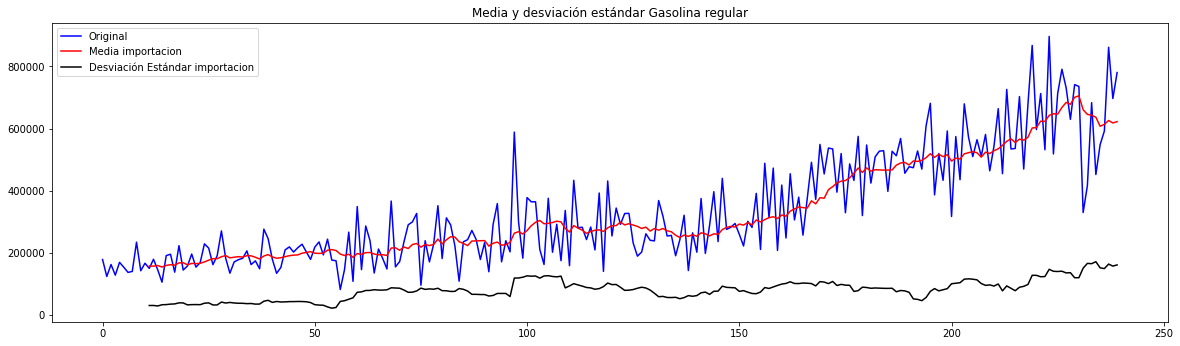

In [ ]:
make_timeline(label_regular)

In [ ]:
train_regular = train_df[['Fecha', label_regular]]
test_regular = test_df[['Fecha', label_regular]]

# Gasolina regular
train_regular[label_regular] = train_regular[label_regular].astype(float)
train_regular_indexed = train_regular.set_index(['Fecha'])

######### TEST ###############
# Gasolina regular
test_regular[label_regular] = test_regular[label_regular].astype(float)
test_regular_indexed = test_regular.set_index(['Fecha'])

In [ ]:
# 2000-01-01 a 2019-12-01
removeCovid = 240
train_regular_indexed = train_regular_indexed[0:removeCovid]
train_regular_gas = train_regular_indexed[label_regular]

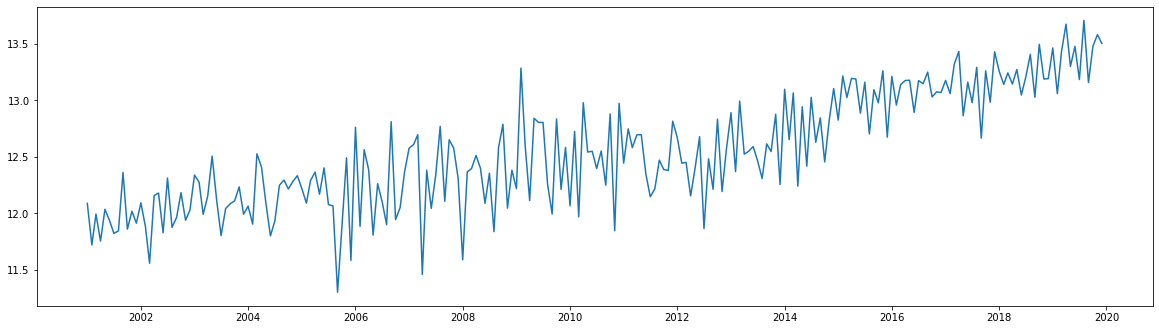

In [ ]:
train_regular_log = np.log(train_regular_gas)
plt.plot(train_regular_log)

## Test de Dickey Fuller 

In [ ]:
train_regular_gas_log_diff = train_regular_gas.diff()
train_regular_gas_log_diff.dropna(inplace=True)

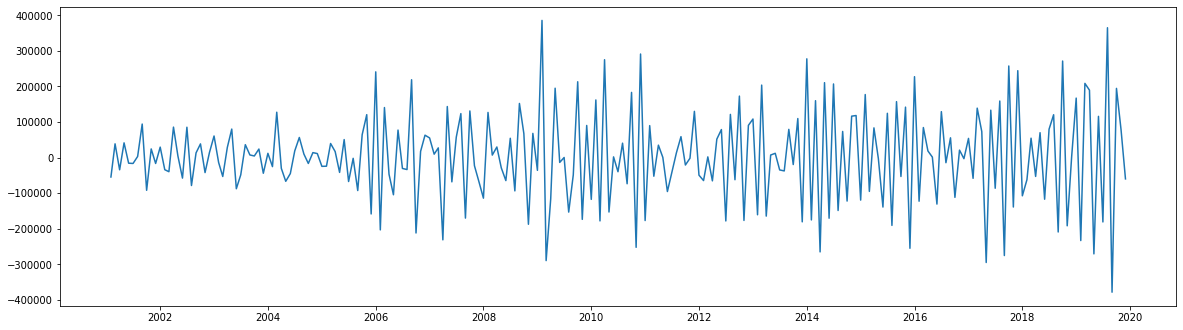

In [ ]:
plt.plot(train_regular_gas_log_diff)

## Mejor modelo ARIMA 121

In [ ]:
model_regular_221 = SARIMAX(
  train_regular_log,
  order=(1,2,1),
  seasonal_order=(3,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_regular_121 = model_regular_121.fit()
print(resultado_regular_121.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8320      0.069    -12.086      0.000      -0.967      -0.697
ar.L2         -0.3683      0.060     -6.182      0.000      -0.485      -0.251
ma.L1         -1.0000    179.209     -0.006      0.996    -352.243     350.243
sigma2         0.2069     37.085      0.006      0.996     -72.479      72.893


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


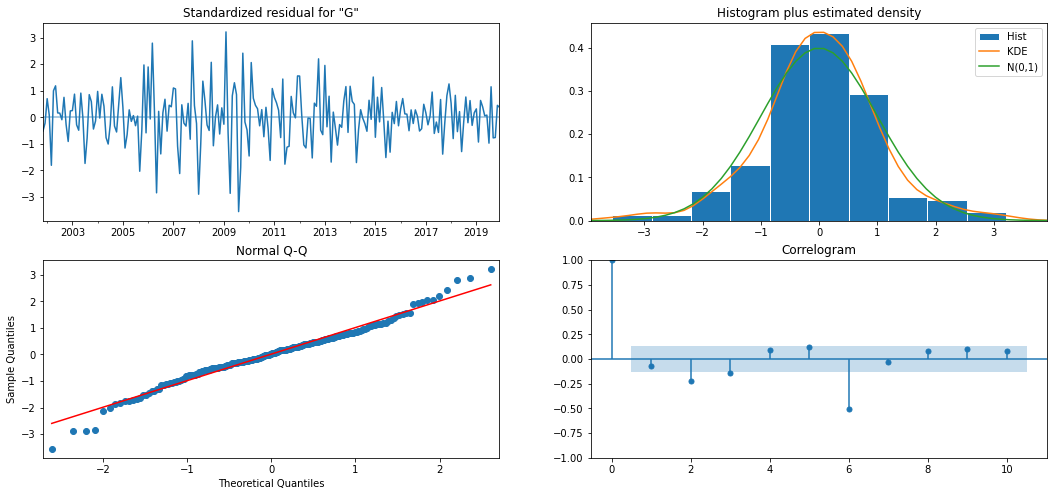

In [ ]:
resultado_regular_221.plot_diagnostics(figsize=(18, 8))
plt.show()

## Prediccion

In [ ]:
df_regular_indexed = df[['Fecha', label_regular]]
df_regular_indexed =  df_regular_indexed.set_index(['Fecha'])

In [ ]:
def checkModel(prediction, test_indexed, label):
  pred = prediction.get_prediction(
    start=test_indexed.index[0],
    end=test_indexed.index[-1],
  ).summary_frame(alpha=0.05)

  fig, ax = plt.subplots(figsize=(15,5))
  test_log = np.log(test_indexed[label])
  ax = test_log.plot(label='Test Data')
  ax.set(
      title='True and Predicted Values, with Confidence Intervals',
      xlabel='Date',
      ylabel='Actual / Predicted Values'
  )

  pred['mean'].plot(ax=ax, style='r', label='Predicted Mean')
  ax.fill_between(
      pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'],
      color='r', alpha=0.1
  )
  legend = ax.legend(loc='upper left')
  plt.show()

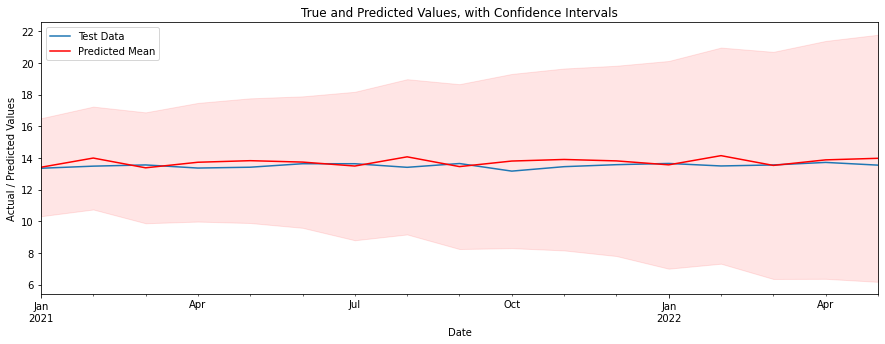

In [ ]:
checkModel(resultado_regular_221, test_regular_indexed, label_regular)